# Dataset Download from Kaggle (robust-lane-detection)

## Google Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download from Kaggle

In [2]:
import os
print(os.getcwd())
from google.colab import files
files.upload() #upload kaggle.json


!pip install -U kaggle==1.5.1
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d junghokim/robust-lane-detection
# !unzip robust-lane-detection.zip -d ./data -q

/content


Saving kaggle.json to kaggle.json
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 132 kB 15.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.1-py3-none-any.whl size=64744 sha256=30a6613b3dca19d449251e550f2298c72ec73a88611d016b01c17e2127e8c11d
  Stored in directory: /root/.cache/pip/wheels/12/e1/d4/d5d5e8c536b2e712b2356c76b9bd37d6248e92f16f9639902a
Successfully built kaggle
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is in

In [3]:
!unzip -qq robust-lane-detection.zip -d ./data 

# Train

## Config

In [49]:
import easydict

# globel param
# dataset setting
img_width = 256
img_height = 128
img_channel = 3
label_width = 256
label_height = 128
label_channel = 1
data_loader_numworkers = 8
class_num = 1

# path
train_path = "/content/drive/MyDrive/Robust_Lane_Detection/train_index.txt"
val_path = "/content/drive/MyDrive/Robust_Lane_Detection/val_index.txt"
# test_path = "/content/data/test_index_demo.txt"
save_path = "/content/drive/MyDrive/Robust_Lane_Detection/Result/"
# pretrained_path='./pretrained/unetlstm.pth'

# weight
class_weight = [0.02, 1.02]

# def args_setting():
#     # Training settings
#     parser = argparse.ArgumentParser(description='Tensorflow UNet-ConvLSTM')
    # parser.add_argument('--model',type=str, default='UNet-ConvLSTM',help='( UNet-ConvLSTM | SegNet-ConvLSTM | UNet | SegNet | ')
#     parser.add_argument('--batch-size', type=int, default=1, metavar='N',
#                         help='input batch size for training (default: 10)')
#     parser.add_argument('--test-batch-size', type=int, default=1, metavar='N',
#                         help='input batch size for testing (default: 100)')
#     parser.add_argument('--epochs', type=int, default=5, metavar='N',
#                         help='number of epochs to train (default: 30)')
#     parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
#                         help='learning rate (default: 0.01)')
#     parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
#                         help='SGD momentum (default: 0.5)')
#     parser.add_argument('--cuda', action='store_true', default=True,
#                         help='use CUDA training')
#     parser.add_argument('--seed', type=int, default=1, metavar='S',
#                         help='random seed (default: 1)')
#     parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                         help='how many batches to wait before logging training status')
#     args = parser.parse_args(args=[])
#     return args

def args_setting():
    args = easydict.EasyDict({
        "model": 'UNet-ConvLSTM',     # help=( UNet-ConvLSTM | SegNet-ConvLSTM | UNet | SegNet | )
        "batch_size" : 5,           # default: 10
        "test_batch_size" : 1,      # default: 100
        "epochs" : 30,              # default: 30
        "lr" : 0.01,                # default: 0.01
        "momentum" : 0.5,           # default: 0.5
        "cuda" : True,              # default: True 
        "seed" : 1,                 # default: 1
        "log_interval" : 10         # default: 10 
    })
    return args

## Utils

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class double_conv(layers.Layer): 
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = keras.Sequential([
            layers.Conv2D(out_ch, (3, 3), padding = "SAME", activation=None), 
            layers.BatchNormalization(momentum=0.9),
            layers.Activation('relu'),
            layers.Conv2D(out_ch, (3, 3), padding = "SAME", activation=None), 
            layers.BatchNormalization(momentum=0.9),
            layers.Activation('relu')            
        ])
    def call(self, x):
        x = self.conv(x)
        return x

class inconv(layers.Layer):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = double_conv(in_ch, out_ch)
    def call(self, x):
        x = self.conv(x)
        return x

class down(layers.Layer):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = keras.Sequential([
            layers.MaxPooling2D(2),
            layers.Conv2D(out_ch, (3, 3), padding = "SAME", activation=None), 
            layers.BatchNormalization(momentum=0.9),
            layers.Activation('relu'),
            layers.Conv2D(out_ch, (3, 3), padding = "SAME", activation=None), 
            layers.BatchNormalization(momentum=0.9),
            layers.Activation('relu') 
        ])

    def call(self, x):
        x = self.mpconv(x)
        return x
        

class up(layers.Layer):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = layers.UpSampling2D(size = (2,2), interpolation='bilinear')
        else:
            self.up = layers.Conv2DTranspose(in_ch//2, 2, stride=(2, 2))

        self.conv = double_conv(in_ch, out_ch)

    def call(self, x1, x2):
        x1 = self.up(x1) 
        diffX = x1.shape[1] - x2.shape[1] # height ?
        diffY = x1.shape[2] - x2.shape[2] # width ?
        padding = [[0,0], [diffX// 2, int((diffX + 1)/ 2)], [diffY // 2, int((diffY+1) / 2)], [0,0]]
        x2 = tf.pad(x2, padding)
        x = layers.concatenate([x2, x1], axis=3)
        x = self.conv(x)
        return x

class outconv(layers.Layer):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = layers.Conv2D(out_ch, (1, 1), padding = "SAME", activation=None)
    def call(self, x):
        x = self.conv(x)
        return x


class ConvLSTMCell(layers.Layer):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super().__init__()

        self.height, self.width = input_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias


        self.conv = keras.Sequential([
            layers.ZeroPadding2D(padding=self.padding),
            layers.Conv2D( #in_channels=self.input_dim + self.hidden_dim,
                              filters=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding="valid",
                              use_bias=self.bias)
        ])

    def call(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = layers.concatenate([input_tensor, h_cur], axis=3)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        for_split_list = []
        
        for i in range(combined_conv.shape[3] // self.hidden_dim):
            for_split_list.append(self.hidden_dim)

        cc_i, cc_f, cc_o, cc_g = tf.split(combined_conv, for_split_list, axis=3) # split 
        i = tf.sigmoid(cc_i)
        f = tf.sigmoid(cc_f)
        o = tf.sigmoid(cc_o)
        g = tf.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * tf.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size):
        return (tf.zeros([batch_size, self.height, self.width, self.hidden_dim]),
                tf.zeros([batch_size, self.height, self.width, self.hidden_dim]))


class ConvLSTM(layers.Layer):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super().__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        # self.cell_list = nn.ModuleList(cell_list)
        self.cell_list = cell_list
        
    def call(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w) -> t = seq num
            # (t, b, h, w, c) -> (b, t, h, w, c)
            input_tensor = tf.transpose(input_tensor, [1, 0, 2, 3, 4])

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.shape[0])

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.shape[1]
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])


                output_inner.append(h)

            layer_output = tf.stack(output_inner, axis=1)
            cur_layer_input = layer_output
            
            layer_output = tf.transpose(layer_output, [1, 0, 2, 3, 4])
            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


## model

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
import operator
# from config import args_setting
import numpy as np

def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf

    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    # print(tf.name_scope)
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        print(sh)
        dim = len(sh[1:-1])
        print(dim)
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        # print(out)
        for i in range(dim, 0, -1):
            # print(i)
            out = tf.concat([out, tf.zeros_like(out)], i)
        print(out)
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        print(out_size)
        out = tf.reshape(out, out_size, name=scope)
    return out


def generate_model(args):

    assert args.model in [ 'UNet-ConvLSTM', 'SegNet-ConvLSTM', 'UNet', 'SegNet']
    if args.model == 'SegNet-ConvLSTM':
        model = SegNet_ConvLSTM()
    elif args.model == 'SegNet':
        model = SegNet()
    elif args.model == 'UNet-ConvLSTM':
        model = UNet_ConvLSTM(img_channel, class_num)
    elif args.model == 'UNet':
        model = UNet(img_channel, class_num)
    return model

class UNet_ConvLSTM(Model):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        self.convlstm = ConvLSTM(input_size=(8,16),
                                 input_dim=512,
                                 hidden_dim=[512, 512],
                                 kernel_size=(3,3),
                                 num_layers=2,
                                 batch_first=False,
                                 bias=True,
                                 return_all_layers=False)

    def call(self, x):
        x = tf.unstack(x, axis=1)
        # data = []
        for idx, item in enumerate(x):
            x1 = self.inc(item)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x5 = self.down4(x4)
            if idx == 0:
                data = tf.expand_dims(x5, axis = 0)
            else:
                data = tf.concat([data, tf.expand_dims(x5, axis = 0)], axis = 0)
            
            # data.append(tf.expand_dims(x5, axis = 0))
        # data = layers.concatenate(data, axis=0)
        
        lstm, _ = self.convlstm(data)
        test = lstm[-1][ -1,:, :, :, :]
        x = self.up1(test, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return tf.math.sigmoid(x)



class UNet(Model):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def call(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

## dataset

In [7]:
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np
# from sklearn import preprocessing

def readTxt(file_path):
    img_list = []
    with open(file_path, 'r') as file_to_read:
        while True:
            lines = file_to_read.readline()
            if not lines:
                break
            item = lines.strip().split()
            img_list.append(item)
    file_to_read.close()
    return img_list

class RoadSequenceDataset(Sequence):

    def __init__(self, file_path):

        self.img_list = readTxt(file_path)
        self.dataset_size = len(self.img_list)
    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        img_path_list = self.img_list[idx]
        data = Image.open(img_path_list[4])
        label = Image.open(img_path_list[5])
        data = image.img_to_array(data)
        label = tf.squeeze(image.img_to_array(label))
        sample = {'data': data, 'label': label}
        return sample

class RoadSequenceDatasetList(Sequence):

    def __init__(self, file_path, batch_size, shuffle = True):
        self.batch_size = batch_size
        self.img_list = readTxt(file_path)
        self.dataset_size = len(self.img_list)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.dataset_size) / self.batch_size)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.dataset_size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        list_id = [self.img_list[k] for k in indexes]
        batch_data = []
        batch_label = []
        if_first = True
        for img_path_list in list_id:
            # img_path_list = self.img_list[idx]
            data = []
            for i in range(5):
                # print(img_path_list[i])
                temp = np.array(image.img_to_array(Image.open(img_path_list[i]))) / 255.
                data.append(tf.expand_dims(temp, axis=0))
                
            data = tf.keras.layers.concatenate(data, 0)
            label = np.array(image.img_to_array(Image.open(img_path_list[5]))) / 255.
            
            # label = tf.squeeze(label)
            label = tf.cast(label, dtype = tf.int32)
            
            if if_first == True:
                temp = np.array(data)
                batch_data = (tf.expand_dims(temp, axis = 0))
                temp = np.array(label)
                batch_label = tf.expand_dims(temp, axis = 0)
            else:
                temp = tf.expand_dims(np.array(data), axis = 0)
                batch_data = tf.keras.layers.concatenate([batch_data, temp], axis = 0)
                temp = tf.expand_dims(np.array(label), axis = 0)
                batch_label = tf.keras.layers.concatenate([batch_label, temp], axis = 0)
            if_first = False
        batch_data = tf.cast(batch_data, dtype=tf.float32)
        batch_label = tf.cast(batch_label, dtype=tf.float32)
        sample = {'data': batch_data, 'label': batch_label}

        return sample

## train

### train - image show

In [ ]:
from re import L
import tensorflow as tf
from tensorflow import keras
from tensorflow import data
from tensorflow.keras.preprocessing import image
from tensorflow.python.ops.numpy_ops.np_math_ops import isnan
import matplotlib.pyplot as plt
import time
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# import tensorflow as tf
# from torchvision import transforms
# from torch.optim import lr_scheduler


physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

def train(args, epoch, model, train_loader, optimizer, criterion):
    since = time.time()
    for batch_idx,  sample_batched in enumerate(train_loader):
        data, target = sample_batched['data'], sample_batched['label']
        # plt.imshow(data)
        np_data = np.array(data)
        np_target = np.array(target)
        print(np_target[0].shape)
        for i in range(128):
          for j in range(256):
            if np_target[0][i][j] == 1:
              np_data[0][4][i][j][0] = 0
              np_data[0][4][i][j][1] = 0
              np_data[0][4][i][j][2] = 0

        for i in range(5):
          plt.imshow(np_data[0][i])
          plt.show()
        np_target = np.squeeze((np_target[0]), axis = 2)
        plt.imshow(np_target)
        plt.show()
        if batch_idx == 5:
          break
        loss = 0
        # with tf.GradientTape() as tape:
        #     output, _ = model(data)
        #     # print(model.summary())
        #     output = tf.convert_to_tensor(output)
        #     # output = tf.keras.layers.Softmax(axis=-1)(output)
        #     # print(target.shape, output.shape)
            
        #     # loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target, logits=output)
        #     print(target.shape)
        #     print(output.shape)
        #     weights = tf.cast(target, dtype=tf.float32) + 0.02
        #     loss = criterion(target, output, sample_weight=weights)
        #     # loss = tf.math.multiply(loss, weights)
            
        #     # print(loss)
        #     # loss = tf.clip_by_value(loss, clip_value_min=0, clip_value_max=float("inf"))
        #     loss = tf.reduce_mean(loss)
        #     # print(loss)
            
        # gradients = tape.gradient(loss, model.trainable_weights)
        # # print(gradients)
        # optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), train_loader.dataset_size,
                100. * batch_idx / len(train_loader), loss))


    time_elapsed = time.time() - since
    print('Train Epoch: {} complete in {:.0f}m {:.0f}s'.format(epoch,
        time_elapsed // 60, time_elapsed % 60))

def val(args, model, val_loader, criterion, epoch):

    loss1= 0
    correct = 0

    for batch_idx, sample_batched in enumerate(val_loader):
        data, target = sample_batched['data'], sample_batched['label']
        
        
        output, _ = model(data)
        # print(model.summary())
        output = tf.convert_to_tensor(output)
        # output = tf.keras.layers.Softmax(axis=-1)(output)
        # print(target.shape, output.shape)
        
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target, logits=output)
        # loss = criterion(target, output)
        weights = tf.cast(target, dtype=tf.float32) + 0.02
        loss = tf.math.multiply(loss, weights)
        
        # print(loss)
        # loss = tf.clip_by_value(loss, clip_value_min=0, clip_value_max=float("inf"))
        loss1 += tf.reduce_mean(loss)

        # pred = tf.math.reduce_max(output, axis = 3, keepdims=True)
        pred = tf.math.argmax(output, axis=3)
        temp = tf.cast(tf.math.equal(pred, tf.cast(target , dtype=tf.int64)), dtype = tf.int32)
        correct += tf.math.reduce_sum(temp)
        
        if batch_idx % (args.log_interval * 10) == 0:
            print(f"Batch[{batch_idx}] Accuracy: {100. * int(correct) / (val_loader.dataset_size * label_height * label_width):.5f}")
            
    loss1 /= (val_loader.dataset_size/args.test_batch_size)
    val_acc = 100. * int(correct) / (val_loader.dataset_size * label_height * label_width)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)\n'.format(
        loss1, int(correct), (val_loader.dataset_size * label_height * label_width), val_acc))
    # model.save(model, '%s.pth'%val_acc)
    model.save_weights('epoch-{}_acc-{}'.format(epoch, val_acc))


if __name__ == '__main__':
    args = args_setting()
    tf.random.set_seed(args.seed)
    # use_cuda = args.cuda and tf.test.is_gpu_available()
    # device = tf.device("gpu" if use_cuda else "cpu")

    # turn image into floatTensor
    # op_tranforms = image.img_to_array()

    # load data for batches, num_workers for multiprocess
    if args.model == 'SegNet-ConvLSTM' or 'UNet-ConvLSTM':
        train_loader = RoadSequenceDatasetList(file_path=train_path, batch_size= args.batch_size, shuffle= True)
        val_loader = RoadSequenceDatasetList(file_path=val_path, batch_size= args.test_batch_size, shuffle= True)
    else:
        train_loader = RoadSequenceDataset(file_path=train_path, batch_size= args.batch_size, shuffle= True)
        val_loader = RoadSequenceDataset(file_path=val_path, batch_size= args.test_batch_size, shuffle= True)

    #load model
    model = generate_model(args)
    scheduler = tf.keras.optimizers.schedules.ExponentialDecay(args.lr, decay_steps=1, decay_rate=0.5, staircase=True)    
    optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
    # optimizer = torch.optim.Adam([
    #     {'params': get_parameters(model, layer_name=["inc", "down1", "down2", "down3", "down4"]), 'lr': args.lr * 0.0},
    #     {'params': get_parameters(model, layer_name=["outc", "up1", "up2", "up3", "up4"]), 'lr': args.lr * 0.1},
    #     {'params': get_parameters(model, layer_name=["convlstm"]), 'lr': args.lr * 1},
    # ], lr=args.lr)
    # optimizer = torch.optim.SGD([
    #     {'params': get_parameters(model, layer_name=["conv1_block", "conv2_block", "conv3_block", "conv4_block", "conv5_block"]), 'lr': args.lr * 0.5},
    #     {'params': get_parameters(model, layer_name=["upconv5_block", "upconv4_block", "upconv3_block", "upconv2_block", "upconv1_block"]), 'lr': args.lr * 0.33},
    #     {'params': get_parameters(model, layer_name=["Conv3D_block"]), 'lr': args.lr * 0.5},
    # ], lr=args.lr,momentum=0.9)

    
    # class_weight = tf.convert_to_tensor(config.class_weight)
    class_weight = tf.convert_to_tensor([3.,3.,3.])

    # criterion = tf.nn.weighted_cross_entropy_with_logits(pos_weight=class_weight, name=None)
    # criterion = torch.nn.CrossEntropyLoss(weight=class_weight)
    criterion = tf.keras.losses.SparseCategoricalCrossentropy()
    # criterion = tf.keras.losses.CategoricalCrossentropy()
    # criterion = tf.nn.sparse_softmax_cross_entropy_with_logits()
    # criterion = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    best_acc = 0

    # pretrained_dict = torch.load(config.pretrained_path)
    # model_dict = model.state_dict()

    # pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if (k in model_dict)}
    # model_dict.update(pretrained_dict_1)
    # model.load_state_dict(model_dict)

    # train
    
    
    # print(train_loader[0]['data'].shape)

    
    # for epoch in range(1, args.epochs+1):
    for epoch in range(1):
        train(args, epoch, model, train_loader, optimizer, criterion)
        # val(args, model, val_loader, criterion, epoch)
    # model.save_weights('model_epoch_5')

Output hidden; open in https://colab.research.google.com to view.

### Real Train - model.fit

1/1 [==============================] - 13s 13s/step - loss: 1.0043 - WBCE: 1.0043


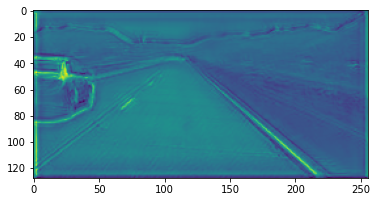

Train Epoch: 0 [0/91660 (0%)]	Loss: 0.000000
1/1 [==============================] - 1s 1s/step - loss: 0.2119 - WBCE: 0.2119


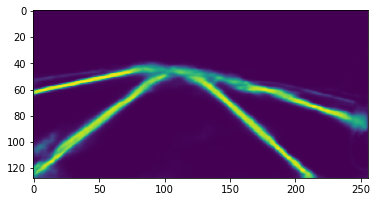

Train Epoch: 0 [5000/91660 (5%)]	Loss: 0.000000
1/1 [==============================] - 1s 1s/step - loss: 0.2229 - WBCE: 0.2229


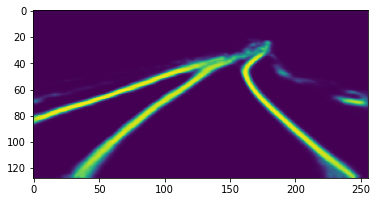

Train Epoch: 0 [10000/91660 (11%)]	Loss: 0.000000
1/1 [==============================] - 1s 1s/step - loss: 0.1573 - WBCE: 0.1573


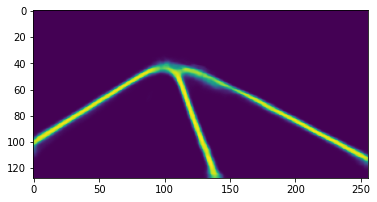

Train Epoch: 0 [15000/91660 (16%)]	Loss: 0.000000
1/1 [==============================] - 1s 1s/step - loss: 0.1608 - WBCE: 0.1608


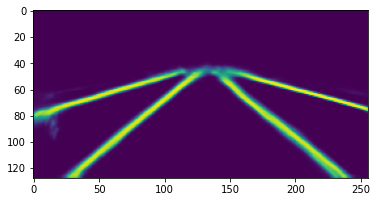

Train Epoch: 0 [20000/91660 (22%)]	Loss: 0.000000
1/1 [==============================] - 1s 1s/step - loss: 0.1537 - WBCE: 0.1537


KeyboardInterrupt: ignored

In [ ]:
from re import L
import tensorflow as tf
from tensorflow import keras
from tensorflow import data
from tensorflow.keras.preprocessing import image
from tensorflow.python.ops.numpy_ops.np_math_ops import isnan
import matplotlib.pyplot as plt
import time
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# import tensorflow as tf
# from torchvision import transforms
# from torch.optim import lr_scheduler

def WBCE(y_true, y_pred):
    epsilon = 1e-7
    return (-1)*tf.math.reduce_mean(tf.math.multiply(tf.math.log(y_pred + epsilon), y_true)*20 + tf.math.multiply(tf.math.log(1-y_pred + epsilon), 1-y_true))

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

def train(args, epoch, model, train_loader, optimizer, criterion, batch_size):
    since = time.time()
    for batch_idx,  sample_batched in enumerate(train_loader):
        data, target = sample_batched['data'], sample_batched['label']
        data = tf.cast(data, dtype=tf.float32)
        target = tf.cast(target, dtype=tf.float32)
        np_data = np.array(data)
        np_target = np.array(target)
        loss = 0
        model.fit(x=data, y=target, batch_size=batch_size, shuffle=False, epochs=1)
        # print(output.shape)
        # with tf.GradientTape() as tape:
        #       output, _ = model(data)
        #     # print(model.summary())
        #     output = tf.convert_to_tensor(output)
        #     # output = tf.keras.layers.Softmax(axis=-1)(output)
        #     # print(target.shape, output.shape)
            
        #     # loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target, logits=output)
        #     print(target.shape)
        #     print(output.shape)
        #     weights = tf.cast(target, dtype=tf.float32) + 0.02
        #     loss = criterion(target, output, sample_weight=weights)
        #     # loss = tf.math.multiply(loss, weights)
            
        #     # print(loss)
        #     # loss = tf.clip_by_value(loss, clip_value_min=0, clip_value_max=float("inf"))
        #     loss = tf.reduce_mean(loss)
        #     # print(loss)
            
        # gradients = tape.gradient(loss, model.trainable_weights)
        # # print(gradients)
        # optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        if batch_idx % args.log_interval == 0:
            output = model(data)
            for_output = np.squeeze((output[0]), axis = 2)
            plt.imshow(for_output)
            plt.show()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), train_loader.dataset_size,
                100. * batch_idx / len(train_loader), loss))


    time_elapsed = time.time() - since
    print('Train Epoch: {} complete in {:.0f}m {:.0f}s'.format(epoch,
        time_elapsed // 60, time_elapsed % 60))

def val(args, model, val_loader, criterion, epoch):

    loss1= 0
    correct = 0

    for batch_idx, sample_batched in enumerate(val_loader):
        data, target = sample_batched['data'], sample_batched['label']
        
        
        output, _ = model(data)
        # print(model.summary())
        output = tf.convert_to_tensor(output)
        # output = tf.keras.layers.Softmax(axis=-1)(output)
        # print(target.shape, output.shape)
        
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target, logits=output)
        # loss = criterion(target, output)
        weights = tf.cast(target, dtype=tf.float32) + 0.02
        loss = tf.math.multiply(loss, weights)
        
        # print(loss)
        # loss = tf.clip_by_value(loss, clip_value_min=0, clip_value_max=float("inf"))
        loss1 += tf.reduce_mean(loss)

        # pred = tf.math.reduce_max(output, axis = 3, keepdims=True)
        pred = tf.math.argmax(output, axis=3)
        temp = tf.cast(tf.math.equal(pred, tf.cast(target , dtype=tf.int64)), dtype = tf.int32)
        correct += tf.math.reduce_sum(temp)
        
        if batch_idx % (args.log_interval * 10) == 0:
            print(f"Batch[{batch_idx}] Accuracy: {100. * int(correct) / (val_loader.dataset_size * label_height * label_width):.5f}")
            
    loss1 /= (val_loader.dataset_size/args.test_batch_size)
    val_acc = 100. * int(correct) / (val_loader.dataset_size * label_height * label_width)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)\n'.format(
        loss1, int(correct), (val_loader.dataset_size * label_height * label_width), val_acc))
    # model.save(model, '%s.pth'%val_acc)
    model.save_weights('epoch-{}_acc-{}'.format(epoch, val_acc))


if __name__ == '__main__':
    args = args_setting()
    tf.random.set_seed(args.seed)
    # use_cuda = args.cuda and tf.test.is_gpu_available()
    # device = tf.device("gpu" if use_cuda else "cpu")

    # turn image into floatTensor
    # op_tranforms = image.img_to_array()

    # load data for batches, num_workers for multiprocess
    if args.model == 'SegNet-ConvLSTM' or 'UNet-ConvLSTM':
        train_loader = RoadSequenceDatasetList(file_path=train_path, batch_size= args.batch_size, shuffle= True)
        val_loader = RoadSequenceDatasetList(file_path=val_path, batch_size= args.test_batch_size, shuffle= True)
    else:
        train_loader = RoadSequenceDataset(file_path=train_path, batch_size= args.batch_size, shuffle= True)
        val_loader = RoadSequenceDataset(file_path=val_path, batch_size= args.test_batch_size, shuffle= True)

    #load model
    model = generate_model(args)
    
    model.compile(optimizer="Adam", loss=WBCE, metrics=[WBCE])
    # model.build(input_shape=(None,5,128,256,3))
    scheduler = tf.keras.optimizers.schedules.ExponentialDecay(args.lr, decay_steps=1, decay_rate=0.5, staircase=True)    
    optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
    # optimizer = torch.optim.Adam([
    #     {'params': get_parameters(model, layer_name=["inc", "down1", "down2", "down3", "down4"]), 'lr': args.lr * 0.0},
    #     {'params': get_parameters(model, layer_name=["outc", "up1", "up2", "up3", "up4"]), 'lr': args.lr * 0.1},
    #     {'params': get_parameters(model, layer_name=["convlstm"]), 'lr': args.lr * 1},
    # ], lr=args.lr)
    # optimizer = torch.optim.SGD([
    #     {'params': get_parameters(model, layer_name=["conv1_block", "conv2_block", "conv3_block", "conv4_block", "conv5_block"]), 'lr': args.lr * 0.5},
    #     {'params': get_parameters(model, layer_name=["upconv5_block", "upconv4_block", "upconv3_block", "upconv2_block", "upconv1_block"]), 'lr': args.lr * 0.33},
    #     {'params': get_parameters(model, layer_name=["Conv3D_block"]), 'lr': args.lr * 0.5},
    # ], lr=args.lr,momentum=0.9)

    
    # class_weight = tf.convert_to_tensor(config.class_weight)
    class_weight = tf.convert_to_tensor([3.,3.,3.])

    # criterion = tf.nn.weighted_cross_entropy_with_logits(pos_weight=class_weight, name=None)
    # criterion = torch.nn.CrossEntropyLoss(weight=class_weight)
    criterion = tf.keras.losses.SparseCategoricalCrossentropy()
    # criterion = tf.keras.losses.CategoricalCrossentropy()
    # criterion = tf.nn.sparse_softmax_cross_entropy_with_logits()
    # criterion = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    best_acc = 0

    # pretrained_dict = torch.load(config.pretrained_path)
    # model_dict = model.state_dict()

    # pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if (k in model_dict)}
    # model_dict.update(pretrained_dict_1)
    # model.load_state_dict(model_dict)

    # train
    
    
    # print(train_loader[0]['data'].shape)

    batch_size = args.batch_size
    # for epoch in range(1, args.epochs+1):
    for epoch in range(1):
        train(args, epoch, model, train_loader, optimizer, criterion, batch_size)
        # val(args, model, val_loader, criterion, epoch)
    # model.save_weights('model_epoch_5')

### GradientTape

In [62]:
import os
from re import L
import tensorflow as tf
from tensorflow import keras
from tensorflow import data
from tensorflow.keras.preprocessing import image
from tensorflow.python.ops.numpy_ops.np_math_ops import isnan
import matplotlib.pyplot as plt
import time
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# import tensorflow as tf
# from torchvision import transforms
# from torch.optim import lr_scheduler

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

def WBCE(y_true, y_pred):
    epsilon = 1e-7
    return (-1)*tf.math.reduce_mean(tf.math.multiply(tf.math.log(y_pred + epsilon), y_true)*20 + tf.math.multiply(tf.math.log(1-y_pred + epsilon), 1-y_true))

def train(args, epoch, model, train_loader, optimizer, batch_size):
    since = time.time()
    for batch_idx,  sample_batched in enumerate(train_loader):
        data, target = sample_batched['data'], sample_batched['label']

        # print(output.shape)

        with tf.GradientTape() as tape:
            output = model(data)
            # output = tf.convert_to_tensor(output)
            loss = WBCE(target, output)
            
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), train_loader.dataset_size,
                100. * batch_idx / len(train_loader), loss))
            for_output = np.squeeze((output[0]), axis = 2)
            plt.imshow(for_output, cmap = 'gray')
            plt.show()

    time_elapsed = time.time() - since
    print('Train Epoch: {} complete in {:.0f}m {:.0f}s'.format(epoch,
        time_elapsed // 60, time_elapsed % 60))

def val(args, model, val_loader, epoch):

    loss1= 0
    correct = 0

    for batch_idx, sample_batched in enumerate(val_loader):
        data, target = sample_batched['data'], sample_batched['label']
        
        output = model(data)
        # output = tf.convert_to_tensor(output)
        
        loss = WBCE(target, output)
        # loss = tf.clip_by_value(loss, clip_value_min=0, clip_value_max=float("inf"))
        loss1 += tf.reduce_mean(loss)

        # pred = tf.math.reduce_max(output, axis = 3, keepdims=True)
        pred = tf.math.argmax(output, axis=3, output_type=tf.int32)
        temp = tf.cast(tf.math.equal(pred, tf.squeeze(tf.cast(target, dtype = tf.int32), axis = 3)), dtype = tf.int32)
        correct += tf.math.reduce_sum(temp)
        
        if batch_idx % (args.log_interval * 10) == 0:
            print(f"Batch[{batch_idx}] Accuracy: {100. * int(correct) / (val_loader.dataset_size * label_height * label_width):.5f}")
            
    loss1 /= (val_loader.dataset_size/args.test_batch_size)
    val_acc = 100. * int(correct) / (val_loader.dataset_size * label_height * label_width)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)\n'.format(
        loss1, int(correct), (val_loader.dataset_size * label_height * label_width), val_acc))
    # model.save(model, '%s.pth'%val_acc)
    os.chdir('/content/drive/MyDrive/Robust_Lane_Detection/Result')
    model.save_weights('epoch-{}_acc-{}'.format(epoch, val_acc))

In [ ]:
if __name__ == '__main__':
    args = args_setting()
    tf.random.set_seed(args.seed)
    
    if args.model == 'SegNet-ConvLSTM' or 'UNet-ConvLSTM':
        train_loader = RoadSequenceDatasetList(file_path=train_path, batch_size= args.batch_size, shuffle= True)
        val_loader = RoadSequenceDatasetList(file_path=val_path, batch_size= args.test_batch_size, shuffle= True)
    else:
        train_loader = RoadSequenceDataset(file_path=train_path, batch_size= args.batch_size, shuffle= True)
        val_loader = RoadSequenceDataset(file_path=val_path, batch_size= args.test_batch_size, shuffle= True)
    model = generate_model(args)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    best_acc = 0
    # pretrained_dict = torch.load(config.pretrained_path)
    # model_dict = model.state_dict()

    # pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if (k in model_dict)}
    # model_dict.update(pretrained_dict_1)
    # model.load_state_dict(model_dict)
    batch_size = args.batch_size

Train Epoch: 0 [0/91660 (0%)]	Loss: 0.269736


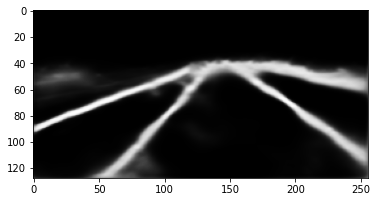

Train Epoch: 0 [50/91660 (0%)]	Loss: 0.286427


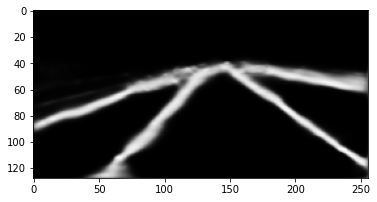

Train Epoch: 0 [100/91660 (0%)]	Loss: 0.289890


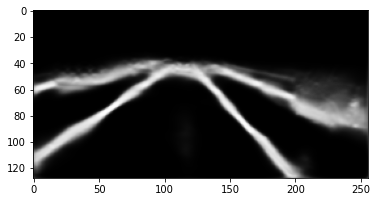

Train Epoch: 0 [150/91660 (0%)]	Loss: 0.318936


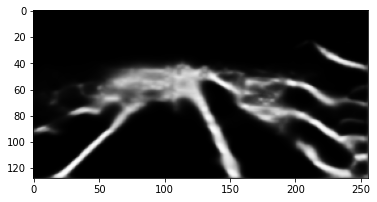

Train Epoch: 0 [200/91660 (0%)]	Loss: 0.254497


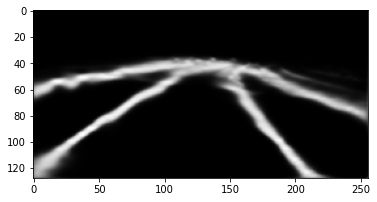

Train Epoch: 0 [250/91660 (0%)]	Loss: 0.276555


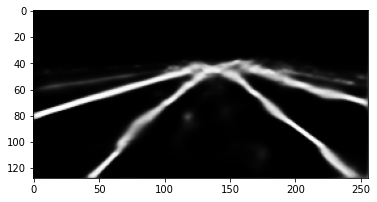

Train Epoch: 0 [300/91660 (0%)]	Loss: 0.252732


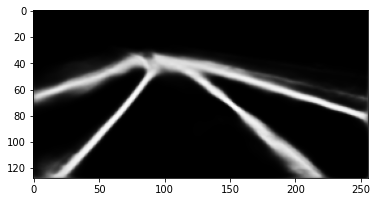

Train Epoch: 0 [350/91660 (0%)]	Loss: 0.308479


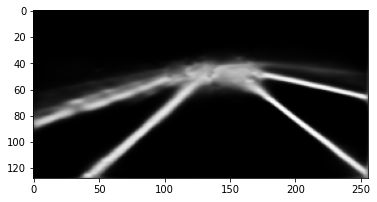

Train Epoch: 0 [400/91660 (0%)]	Loss: 0.224363


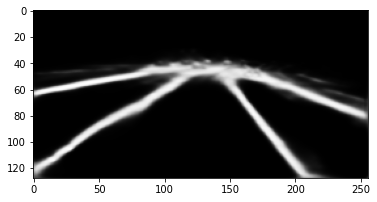

Train Epoch: 0 [450/91660 (0%)]	Loss: 0.179406


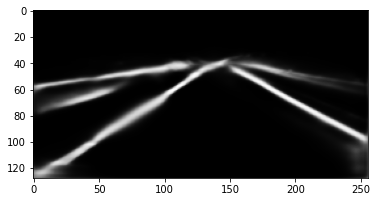

Train Epoch: 0 [500/91660 (1%)]	Loss: 0.237689


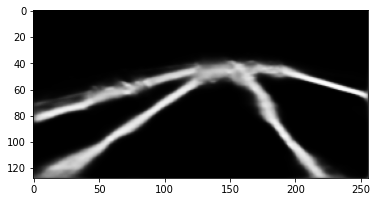

Train Epoch: 0 [550/91660 (1%)]	Loss: 0.278465


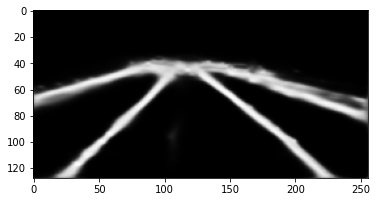

Train Epoch: 0 [600/91660 (1%)]	Loss: 0.223689


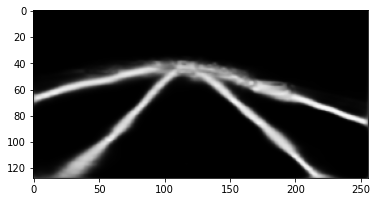

Train Epoch: 0 [650/91660 (1%)]	Loss: 0.178877


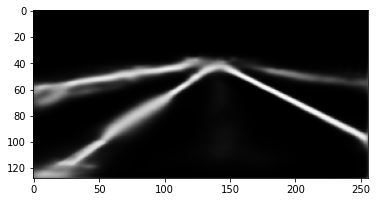

Train Epoch: 0 [700/91660 (1%)]	Loss: 0.352546


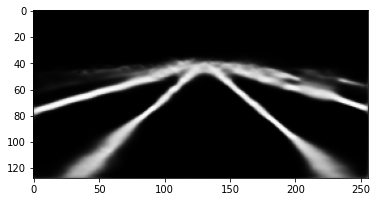

Train Epoch: 0 [750/91660 (1%)]	Loss: 0.234329


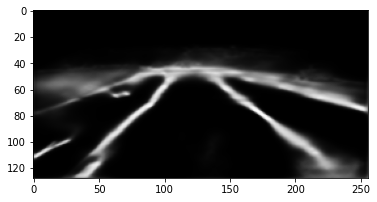

Train Epoch: 0 [800/91660 (1%)]	Loss: 0.240116


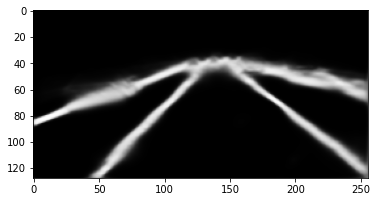

Train Epoch: 0 [850/91660 (1%)]	Loss: 0.253119


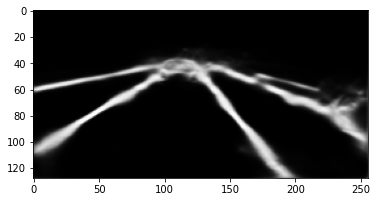

Train Epoch: 0 [900/91660 (1%)]	Loss: 0.340553


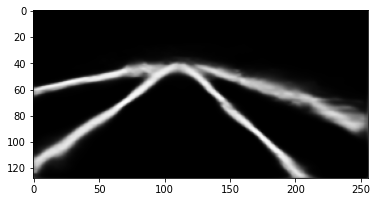

Train Epoch: 0 [950/91660 (1%)]	Loss: 0.338693


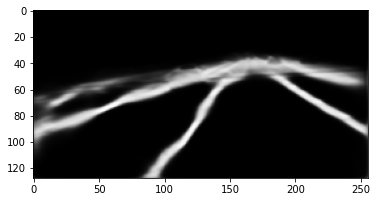

Train Epoch: 0 [1000/91660 (1%)]	Loss: 0.296014


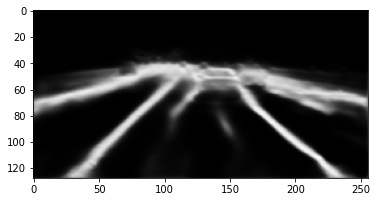

Train Epoch: 0 [1050/91660 (1%)]	Loss: 0.206547


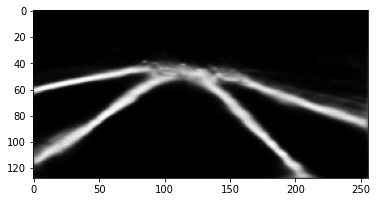

Train Epoch: 0 [1100/91660 (1%)]	Loss: 0.283004


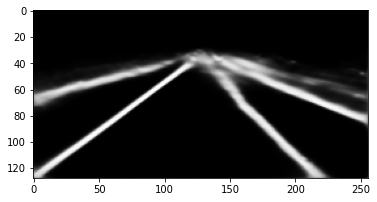

Train Epoch: 0 [1150/91660 (1%)]	Loss: 0.249994


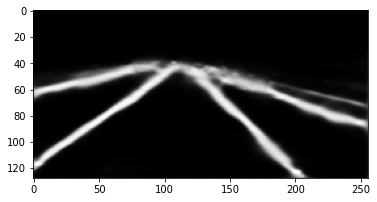

Train Epoch: 0 [1200/91660 (1%)]	Loss: 0.222749


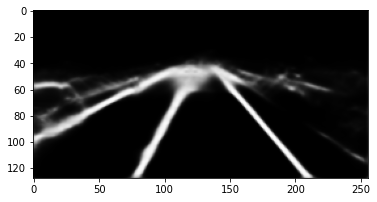

In [ ]:
for epoch in range(1):
    train(args, epoch, model, train_loader, optimizer, batch_size)
    val(args, model, val_loader, epoch)